In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pywt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import skfda

## Read MS Data

### Visualize MS Data

In [ ]:
def visualizeRawMS(data):
    plt.figure(figsize=(12.5, 5))
    plt.plot(data["M.Z"], data["Intensity"], linestyle='-')
    plt.xlabel("m/z")
    plt.ylabel("intensity")
    plt.show()

## Segment Data 

In [ ]:
def segmentData(data, n, N):
    # Matrix Z of (N x n)
    intensity_values = data.iloc[:, 1].values
    usable_values = n * N  # 32,768 intensity values
    intensity_values_trimmed = intensity_values[:usable_values]
    
    Z = np.array([intensity_values_trimmed[i*N:(i+1)*N] for i in range(n)]).T

    return Z

## Apply DWT to each window

In [ ]:
def applyDWT(Z):
    # Wavelet family
    wavelet = 'bior3.1'
    
    cA_values = []
    cD_values = []
    
    for i in range(Z.shape[1]):
        cA, cD = pywt.dwt(Z[:, i], wavelet)  # Apply DWT to the i-th column
        cA_values.append(cA)  # Use append to add each cA
        cD_values.append(cD)  # Use append to add each cD
    
    cA_values = np.array(cA_values)  # Shape: (64, 128)
    cD_values = np.array(cD_values)  # Shape: (64, 128)

    return cA_values.T, cD_values.T

## Extract Statistical Descriptors for cA and cD (approximation, detailed)

In [ ]:
# Define function to extract 
def extract_features(w):
    energy = np.sum(w**2)
    mean = np.mean(w)
    variance = np.var(w)
    cv = (np.sqrt(variance))/mean
    skewness = stats.skew(w)
    kurtosis = stats.kurtosis(w)
    return [energy, mean, variance, skewness, kurtosis, cv]

In [ ]:
def displayStatisticalFeatures(features):
    features_labels = ["Energy", "Mean", "Variance", "Skewness", "Kurtosis", "CV"]
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    for i, ax in enumerate(axes.flatten()):
        sns.histplot(features[:, i], bins=30, kde=True, ax=ax)
        ax.set_title(features_labels[i])
        
    plt.tight_layout()
    plt.show()

## Apply PCA to feature matracies

In [ ]:
# Do before applying PCA follow below
# scaler = StandardScaler()

# feature_a_scaled = scaler.fit_transform(feature_a)
# feature_d_scaled = scaler.fit_transform(feature_d)

# min_variance = 0.90
# max_variance = 0.95


def pca_with_variance(data, min_var, max_var):
    # Fit PCA
    pca = PCA().fit(data)
    
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    
    valid_indices = np.where((cumsum_var >= min_var) & (cumsum_var <= max_var))[0]
    
    if len(valid_indices) == 0:
        raise ValueError(f"No principal components retain between {min_var:.2f} and {max_var:.2f} variance.")
    
    n_components = valid_indices[-1] + 1 

    pca = PCA(n_components=n_components)
    
    return pca, pca.fit_transform(data)

# pca_a, Z_a = pca_with_variance(feature_a_scaled, min_variance, max_variance)
# pca_d, Z_d = pca_with_variance(feature_d_scaled, min_variance, max_variance)

# # Checking shapes to ensure valid
# print(Z_a.shape)
# print(Z_d.shape)

In [ ]:
def inverse_lambda(x):
    try:
        inverse_matrix = np.linalg.inv(x)
        return inverse_matrix
    except np.linalg.LinAlgError:
        print("The matrix is singular and does not have an inverse.")
        return None

# Function to compute T² values for each sample
def computeT2(Z, P, Lambda_inv):
    # Project the data into PCA space
    ZP = np.dot(Z, P)  # Shape: (N_samples, n_components)

    # Compute T² for each sample using the quadratic form:
    # T² = zPᵢᵗ * Λ⁻¹ * zPᵢ
    T2 = np.einsum('ij,jk,ik->i', ZP, Lambda_inv, ZP)  # Shape: (N_samples,)
    return T2

## T2

In [12]:
"""
T2 = sqrt[((T2_a_j)**2) + ((T2_d_j)**2)]
"""
def calc_T2_original(a, d):
    assert(len(a) == len(d))
    res = np.sqrt(a+d)
    return res

# T2_original = calc_T2_original(T2_a, T2_d)
# print(T2_original.shape)
# Result: 140.87228258248672

## Develop SVM based on T2

In [13]:
import os
import glob

cancer_path = './datasets/Cancer/'
normal_path = './datasets/Normal/'

windows = 64
window_size = 512

def process_directory(directory, n, N):
    all_files = glob.glob(os.path.join(directory, "*.csv"))
    t2_stats = []
    
    for file in all_files:
        df = pd.read_csv(file)
        
        Z = segmentData(df, n, N)
        
        cA, cD = applyDWT(Z)

        feature_a = np.array([extract_features(cA[:, i]) for i in range(n)])
        feature_d = np.array([extract_features(cD[:, i]) for i in range(n)])

        scaler = StandardScaler()
        feature_a_scaled = scaler.fit_transform(feature_a)
        feature_d_scaled = scaler.fit_transform(feature_d)
        min_variance = 0.80
        max_variance = 0.95

        try:
            pca_a, Z_a = pca_with_variance(feature_a_scaled, min_variance, max_variance)
            pca_d, Z_d = pca_with_variance(feature_d_scaled, min_variance, max_variance)
    
            P_feat_a = pca_a.components_.T
            Lambda_feat_a = np.diag(pca_a.explained_variance_)
            P_feat_d = pca_d.components_.T
            Lambda_feat_d = np.diag(pca_d.explained_variance_)
            Lambda_feat_a_inv = inverse_lambda(Lambda_feat_a)
            Lambda_feat_d_inv = inverse_lambda(Lambda_feat_d)
    
            T2_a = computeT2(feature_a_scaled, P_feat_a, Lambda_feat_a_inv)
            T2_d = computeT2(feature_d_scaled, P_feat_d, Lambda_feat_d_inv)
    
            T2_stat = calc_T2_original(T2_a, T2_d)
    
            t2_stats.append(T2_stat)
        except ValueError as e:
            print(f"Skipping file {file} due to PCA variance issue: {e}")
            continue
    
    return t2_stats

cancer = np.array(process_directory(cancer_path, windows, window_size))
normal = np.array(process_directory(normal_path, windows, window_size))

Skipping file ./datasets/Normal\NO217.csv due to PCA variance issue: No principal components retain between 0.80 and 0.95 variance.


In [14]:
print(cancer.shape)
print(normal.shape)

(49, 64)
(29, 64)


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

X = np.vstack((cancer, normal))
y = np.array([1] * len(cancer) + [-1] * len(normal))

In [16]:
X.shape

(78, 64)

In [ ]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Cross validation for hyper-param tuning
param_grid = {'C': [2**i for i in range(-8, 9)], 'gamma': [2**i for i in range(-10, 11)], 'kernel': ['rbf', 'linear', 'poly']}
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_resampled, y_resampled)

print("Best hyperparameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best hyperparameters: {'C': 0.03125, 'gamma': 0.0009765625, 'kernel': 'linear'}
Best score: 0.8608333333333335


In [19]:
y_pred = grid.predict(X_test)

In [20]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
    
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
TP, FN, FP, TN = cm.ravel()
    
# Sensitivity (Recall for positive class)
sensitivity = TP / (TP + FN)
    
# Specificity (True Negative Rate)
specificity = TN / (TN + FP)
    
# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


Accuracy: 0.75
Sensitivity (Recall): 0.67
Specificity: 0.80


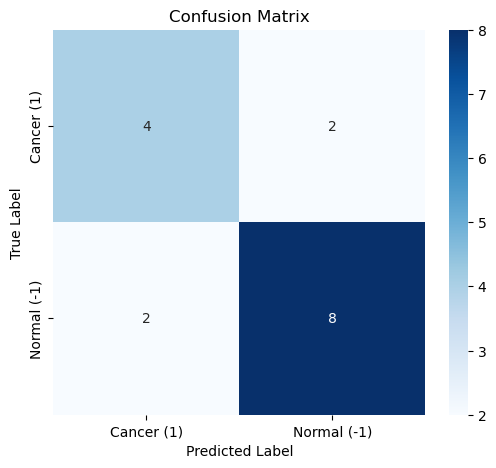

In [21]:
class_labels = ["Cancer (1)", "Normal (-1)"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()